In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from pytorch_pretrained_bert import BertTokenizer
from mmbt.models.mmtr import MMTransformerGMU5MoviescopeClf
from mmbt.data.dataset import JsonlDataset
from mmbt.data.vocab import Vocab
from mmbt.data.helpers import collate_fn

In [164]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from collections import OrderedDict
import json
import os
import seaborn as sns
import pandas as pd
import json
from wordcloud import WordCloud

In [4]:
def load_model(path):
    # load weights
    mult_weights_ = torch.load(f'{path}/model_best.pt', map_location=torch.device('cuda:2'))['state_dict']

    # models are saved in DataParallel, delete that part
    mult_weights = OrderedDict()
    for k, v in mult_weights_.items():
        name = k[7:]
        mult_weights[name] = v
    
    # load configuration file for model
    args = torch.load(f'{path}/args.pt')
    model = MMTransformerGMU5MoviescopeClf(args)
    # load pretrained weights
    model.load_state_dict(mult_weights)
    model.eval();
    
    return model

### Load model and test dataset

Load model

In [5]:
args = torch.load('model_save_mmtr/moviescope_VideoTextAudioPosterMetaGMUSeed5_mmtr_model_run/args.pt')
model = load_model('model_save_mmtr/moviescope_VideoTextAudioPosterMetaGMUSeed5_mmtr_model_run')

Load test Dataset and preprocessing tools

In [6]:
tokenizer = BertTokenizer.from_pretrained(args.bert_model, do_lower_case=True).tokenize
id2token = BertTokenizer.from_pretrained(args.bert_model, do_lower_case=True).convert_ids_to_tokens

model_transforms = transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.46777044, 0.44531429, 0.40661017],
                std=[0.12221994, 0.12145835, 0.14380469],
            ),
        ]
    )

test_set = JsonlDataset(
    os.path.join(args.data_path, args.task, "test.jsonl"),
    tokenizer,
    model_transforms,
    args.vocab,
    args,
)

In [7]:
id2setidx = {int(json.loads(l)['id']): i for i, l in enumerate(open(os.path.join(args.data_path, args.task, "test.jsonl")))}

### Get intermediate attention matrices with Hooks

In [8]:
def get_pred_hooks(model, test_set, example_id, activations_dict):
    
    # Build a new hook function that saves output of layer 'name' into 'activations_dict'
    def get_activation(name):
        def hook(model, input, output):
            activations_dict[name] = output[1].detach()
        return hook
    
    handles = []

    for num_layer in range(5):
        # language
        handles.append(model.trans_l_with_v.layers[num_layer].self_attn.register_forward_hook(get_activation(f'trans_l_with_v.layers.'+str(num_layer)+'.self_attn')))
        handles.append(model.trans_l_with_a.layers[num_layer].self_attn.register_forward_hook(get_activation(f'trans_l_with_a.layers.'+str(num_layer)+'.self_attn')))
        # vision
        handles.append(model.trans_v_with_l.layers[num_layer].self_attn.register_forward_hook(get_activation(f'trans_v_with_l.layers.'+str(num_layer)+'.self_attn')))
        #handles.append(model.trans_v_with_a.layers[num_layer].self_attn.register_forward_hook(get_activation(f'trans_v_with_a.layers.'+str(num_layer)+'.self_attn')))
        # audio
        handles.append(model.trans_a_with_l.layers[num_layer].self_attn.register_forward_hook(get_activation(f'trans_a_with_l.layers.'+str(num_layer)+'.self_attn')))
        #handles.append(model.trans_a_with_v.layers[num_layer].self_attn.register_forward_hook(get_activation(f'trans_a_with_v.layers.'+str(num_layer)+'.self_attn')))
    
    # Get model input
    txt, segment, mask, img, tgt, audio, poster, metadata = collate_fn([test_set[example_id]], args)
    out = model(txt, mask, segment, img, audio, poster, metadata)
    
    # Remove hooks
    for h in handles:
        h.remove()
    
    return txt

In [9]:
def get_pred_gradient_hooks(model, test_set, example_id, activations_dict):
    
    # Build a new hook function that saves output of layer 'name' into 'activations_dict'
    def get_activation(name):
        def hook(model, input, output):
            activations_dict[name] = output[1]
        return hook
    
    # Get embeddgins
    def get_embeddings(name):
        def hook(model, input, output):
            activations_dict[name] = output
        return hook

    handles = []
    
    for num_layer in range(5):
        # corss-modal embeddings
        handles.append(model.trans_l_with_v.layers[num_layer].register_forward_hook(get_embeddings(f'trans_l_with_v.emb.'+str(num_layer))))
        # text embeddings
        handles.append(model.enc.bert.embeddings.register_forward_hook(get_embeddings(f'embeddings')))
    
    # Get model input
    txt, segment, mask, img, tgt, audio, poster, metadata = collate_fn([test_set[example_id]], args)
    out = model(txt, mask, segment, img, audio, poster, metadata)
    
    # Remove hooks
    for h in handles:
        h.remove()

    return txt

### Function to get highest activation sequence elements from one modality with respect to another from an attention matrix

In [10]:
def get_max_activation_elements(activations, layer_type, axis_to_reduce):
    
    layer_activation = activations[f'{layer_type}.layers.0.self_attn'].squeeze(0).clone().numpy()
    for i in range(1, 4):
        layer_activation += activations[f'{layer_type}.layers.{i}.self_attn'].squeeze(0).clone().numpy()
        
    return np.sum(layer_activation, axis_to_reduce)

### Function to visualize attention values over text tokens

In [11]:
def colorize(words, color_array):
    # words is a list of words
    # color_array is an array of numbers between 0 and 1 of length equal to words
    cmap = matplotlib.cm.get_cmap('Wistia')
    template = '<span class="barcode"; style="color: black; background-color: {}">{}</span>'
    colored_string = ''
    for i, (word, color) in enumerate(zip(words, color_array)):
        color = matplotlib.colors.rgb2hex(cmap(color)[:3])
        if i%20==0 and i>0:
            colored_string += template.format(color, '&nbsp' + word + '&nbsp' + '<br>')
        else:
            colored_string += template.format(color, '&nbsp' + word + '&nbsp')
    return colored_string

### Function to visualize attention matrices

In [12]:
def show(img, txt_tokens, row_srt=0, row_end=None, col_srt=0, col_end=None):
    npimg = img.numpy()
    
    if row_end is None:
        row_end = npimg.shape[0]
    if col_end is None:
        col_end = npimg.shape[1]
    
    fig, ax = plt.subplots(figsize=(15, 15))
    ax.imshow(npimg[row_srt:row_end, col_srt:col_end], interpolation='nearest')
    #plt.yticks(range(row_srt, row_end), txt_tokens[row_srt:row_end])
    #plt.xticks(range(col_srt, col_end), txt_tokens[col_srt:col_end])
    #plt.xticks(rotation = 45) 
    plt.tight_layout()
    #fig.savefig('lv_att.png')

## Some examples

### Example with highest GMU activation for text modality

Get attention matrices of cross-modal layers

In [269]:
activations = {}

example_text = get_pred_hooks(model, test_set, id2setidx[3899], activations)

/001/usuarios/isaac.bribiesca/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/001/usuarios/isaac.bribiesca/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Get text tokens

In [281]:
text_tokens = id2token(example_text.detach().squeeze(0).numpy())
print(text_tokens)
print(len(text_tokens))

['[CLS]', 'crippled', 'trap', '##ez', '##e', 'aerial', '##ist', 'and', 'former', 'star', 'mike', 'rib', '##ble', 'sees', 'great', 'promise', 'in', 'young', ',', 'bra', '##sh', 'tin', '##o', 'or', '##sin', '##i', '.', 'rib', '##ble', '—', 'only', 'the', 'sixth', 'man', 'to', 'have', 'completed', 'the', 'dangerous', 'triple', 'some', '##rsa', '##ult', '—', 'thinks', 'his', 'protege', 'is', 'capable', ',', 'under', 'his', 'rigorous', 'training', ',', 'of', 'matching', 'his', 'feat', '.', 'however', ',', 'or', '##sin', '##i', 'is', 'distracted', 'by', 'the', 'third', 'member', 'of', 'their', 'circus', 'act', ',', 'the', 'mani', '##pu', '##lative', 'lola', '.', 'tensions', 'rise', 'as', 'a', 'love', 'triangle', 'forms', '.']
90


Inspect and visualize attention matrices

In [15]:
for layer_name, tensor in activations.items():
    print(f'{layer_name}: {tensor.shape}')

trans_l_with_a.layers.0.self_attn: torch.Size([1, 90, 200])
trans_l_with_a.layers.1.self_attn: torch.Size([1, 90, 200])
trans_l_with_a.layers.2.self_attn: torch.Size([1, 90, 200])
trans_l_with_a.layers.3.self_attn: torch.Size([1, 90, 200])
trans_l_with_a.layers.4.self_attn: torch.Size([1, 90, 200])
trans_l_with_v.layers.0.self_attn: torch.Size([1, 90, 200])
trans_l_with_v.layers.1.self_attn: torch.Size([1, 90, 200])
trans_l_with_v.layers.2.self_attn: torch.Size([1, 90, 200])
trans_l_with_v.layers.3.self_attn: torch.Size([1, 90, 200])
trans_l_with_v.layers.4.self_attn: torch.Size([1, 90, 200])
trans_a_with_l.layers.0.self_attn: torch.Size([1, 200, 90])
trans_a_with_l.layers.1.self_attn: torch.Size([1, 200, 90])
trans_a_with_l.layers.2.self_attn: torch.Size([1, 200, 90])
trans_a_with_l.layers.3.self_attn: torch.Size([1, 200, 90])
trans_a_with_l.layers.4.self_attn: torch.Size([1, 200, 90])
trans_v_with_l.layers.0.self_attn: torch.Size([1, 200, 90])
trans_v_with_l.layers.1.self_attn: torch

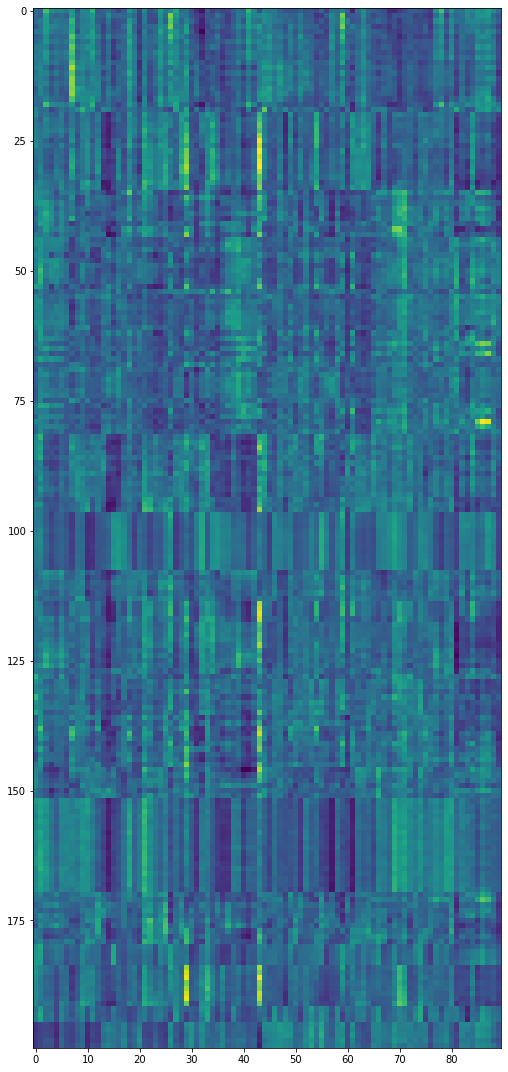

In [16]:
show(activations[f'trans_v_with_l.layers.0.self_attn'].squeeze(0), text_tokens)

In [382]:
torch.sum(activations[f'trans_v_with_l.layers.0.self_attn'].squeeze(0), dim=1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 

Which modality (video or audio) has more relevance by text token

In [270]:
# sum of video attentions by text token for all layers
video_attention_by_token = get_max_activation_elements(activations, 'trans_v_with_l', 0)
# sum of audio attentions by text token for all layers
audio_attention_by_token = get_max_activation_elements(activations, 'trans_a_with_l', 0)
# concatenate both attention sums
vid_aud_attention_by_token = np.stack([video_attention_by_token, audio_attention_by_token], axis=1)
# take modality with highest attention for each token
max_modality_by_token = np.argmax(vid_aud_attention_by_token, axis=1)

In [272]:
max_modality_by_token

array([0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0,
       1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1,
       1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1,
       1, 1])

In [273]:
s = colorize(text_tokens, max_modality_by_token/2)

# to display in ipython notebook
from IPython.display import display, HTML
display(HTML(s))

Frames attention by text token (take top frames attention by token)

In [274]:
frames_attention_by_token = activations['trans_l_with_v.layers.0.self_attn'].squeeze(0).clone().detach().numpy()
top_idxs_by_token = np.argsort(frames_attention_by_token, axis=1)[:,-20:]

In [275]:
top_idxs_by_token

array([[ 85,  46,  95, ..., 102, 101, 109],
       [ 54,  34,  23, ...,  98, 111, 109],
       [ 95,  62,  61, ..., 110, 112, 111],
       ...,
       [135, 170, 179, ..., 102, 137, 101],
       [170, 172, 146, ..., 101, 179, 137],
       [103,  97, 111, ..., 170, 137, 179]])

Text with visual attention (v_with_l)

In [276]:
attention_values = get_max_activation_elements(activations, 'trans_v_with_l', 0)
max_idxs = attention_values.argsort()[-10:][::-1]

for i in range(attention_values.shape[0]):
    if i not in max_idxs:
        attention_values[i] = 0

In [277]:
s = colorize(text_tokens, attention_values)

# to display in ipython notebook
from IPython.display import display, HTML
display(HTML(s))

Text with audio attention (a_with_l)

In [278]:
attention_values = get_max_activation_elements(activations, 'trans_a_with_l', 0)
max_idxs = attention_values.argsort()[-10:][::-1]

for i in range(attention_values.shape[0]):
    if i not in max_idxs:
        attention_values[i] = 0

In [279]:
s = colorize(text_tokens, attention_values)

# to display in ipython notebook
from IPython.display import display, HTML
display(HTML(s))

Visualize major regions of attention by video or audio per token

#### Video

In [282]:
frames_attention_by_token = activations[f'trans_l_with_v.layers.0.self_attn'].squeeze(0).clone().numpy()
for i in range(1, 4):
    frames_attention_by_token += activations[f'trans_l_with_v.layers.{i}.self_attn'].squeeze(0).clone().numpy()

top_idxs_by_token = np.argsort(frames_attention_by_token, axis=1)[:,-20:]
mean_pos_by_token = pd.DataFrame({"token": text_tokens, "mean_pos": np.mean(top_idxs_by_token, axis=1).tolist()})

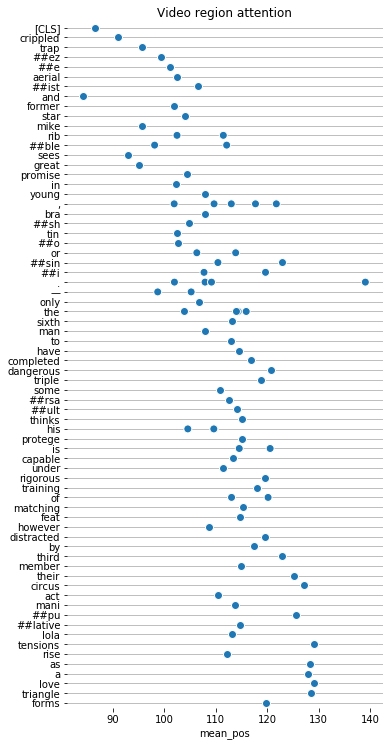

In [283]:
#sns.set_theme(style="whitegrid")

# Make the PairGrid
g = sns.PairGrid(mean_pos_by_token,
                 x_vars=["mean_pos"], y_vars=["token"],
                 height=10, aspect=.5)

# Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=8, orient="h", jitter=False,
      linewidth=1, edgecolor="w")

# Use the same x axis limits on all columns and add better labels
#g.set(xlim=(0, 200), xlabel="mean_pos", ylabel="")
g.set(xlabel="mean_pos", ylabel="")

ax = g.axes.flat[0]
# Set a different title for each axes
ax.set(title="Video region attention")

# Make the grid horizontal instead of vertical
ax.xaxis.grid(False)
ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)

In [284]:
positions_by_token = pd.DataFrame(columns=['pos','token'])

for i, row in enumerate(top_idxs_by_token):
    for col in row:
        positions_by_token = positions_by_token.append({'pos': col, 'token': text_tokens[i]}, ignore_index=True)

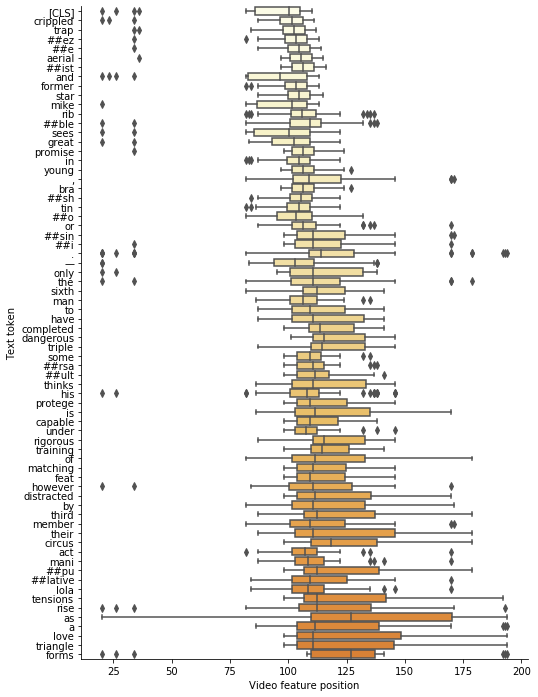

In [285]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 12)
sns.boxplot(x="pos", y="token", data=positions_by_token, ax=ax, palette=sns.color_palette("YlOrBr", 120)).set(
    xlabel='Video feature position', 
    ylabel='Text token'
)
sns.despine()

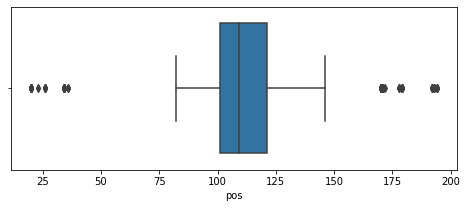

In [286]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 3)
sns.boxplot(x=positions_by_token.pos, ax=ax)

#### Audio

In [287]:
frames_attention_by_token = activations[f'trans_l_with_a.layers.0.self_attn'].squeeze(0).clone().numpy()
for i in range(1, 4):
    frames_attention_by_token += activations[f'trans_l_with_a.layers.{i}.self_attn'].squeeze(0).clone().numpy()

top_idxs_by_token = np.argsort(frames_attention_by_token, axis=1)[:,-20:]
mean_pos_by_token = pd.DataFrame({"token": text_tokens, "mean_pos": np.mean(top_idxs_by_token, axis=1).tolist()})

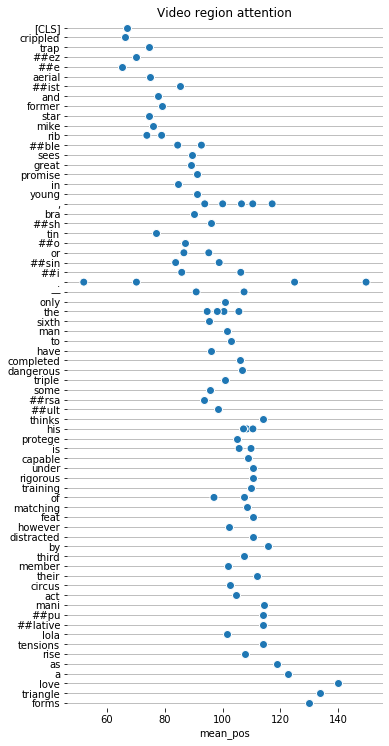

In [109]:
#sns.set_theme(style="whitegrid")

# Make the PairGrid
g = sns.PairGrid(mean_pos_by_token,
                 x_vars=["mean_pos"], y_vars=["token"],
                 height=10, aspect=.5)

# Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=8, orient="h", jitter=False,
      linewidth=1, edgecolor="w")

# Use the same x axis limits on all columns and add better labels
#g.set(xlim=(0, 200), xlabel="mean_pos", ylabel="")
g.set(xlabel="mean_pos", ylabel="")

ax = g.axes.flat[0]
# Set a different title for each axes
ax.set(title="Video region attention")

# Make the grid horizontal instead of vertical
ax.xaxis.grid(False)
ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)

In [288]:
positions_by_token = pd.DataFrame(columns=['pos','token'])

for i, row in enumerate(top_idxs_by_token):
    for col in row:
        positions_by_token = positions_by_token.append({'pos': col, 'token': text_tokens[i]}, ignore_index=True)

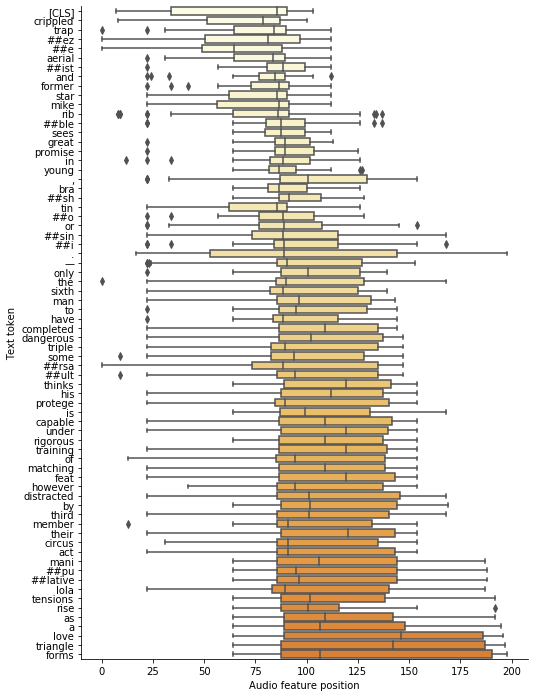

In [289]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 12)
sns.boxplot(x="pos", y="token", data=positions_by_token, ax=ax, palette=sns.color_palette("YlOrBr", 120)).set(
    xlabel='Audio feature position', 
    ylabel='Text token'
)
sns.despine()

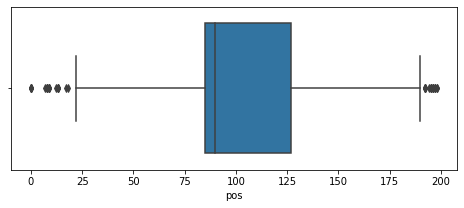

In [205]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 3)
sns.boxplot(x=positions_by_token.pos, ax=ax)

### Example with highest GMU activation for audio modality

In [247]:
activations = {}

example_text = get_pred_hooks(model, test_set, id2setidx[3015], activations)

/001/usuarios/isaac.bribiesca/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/001/usuarios/isaac.bribiesca/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Get text tokens

In [248]:
text_tokens = id2token(example_text.detach().squeeze(0).numpy())
print(text_tokens)
print(len(text_tokens))

['[CLS]', 'the', 'film', 'closely', 'follows', 'b', '##ly', "'", 's', 'original', 'account', ',', 'and', 'extracts', 'much', 'of', 'the', 'dialogue', 'from', 'b', '##ly', '’', 's', '1880s', 'expose', 'ten', 'days', 'in', 'a', 'mad', '-', 'house', '.', 'in', 'an', 'interview', 'on', 'los', 'angeles', 'talk', 'radio', ',', 'caroline', 'barry', 'recounts', 'christopher', 'lambert', 'bringing', 'authenticity', 'to', 'the', 'part', 'of', 'the', 'antagonist', 'dr', '.', 'dent', ',', 'by', 'portraying', 'his', 'motives', 'as', 'mis', '##guide', '##d', 'good', 'intent', 'rather', 'than', 'evil', '.', 'which', 'she', 'feels', 'adds', 'to', 'the', 'realism', 'of', 'the', 'bio', '##pic', '.']
85


Which modality (video or audio) has more relevance by text token

In [249]:
# sum of video attentions by text token for all layers
video_attention_by_token = get_max_activation_elements(activations, 'trans_v_with_l', 0)
# sum of audio attentions by text token for all layers
audio_attention_by_token = get_max_activation_elements(activations, 'trans_a_with_l', 0)
# concatenate both attention sums
vid_aud_attention_by_token = np.stack([video_attention_by_token, audio_attention_by_token], axis=1)
# take modality with highest attention for each token
max_modality_by_token = np.argmax(vid_aud_attention_by_token, axis=1)

In [250]:
max_modality_by_token

array([1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0,
       1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0])

In [251]:
s = colorize(text_tokens, max_modality_by_token/2)

# to display in ipython notebook
from IPython.display import display, HTML
display(HTML(s))

Frames attention by text token (take top frames attention by token)

In [252]:
frames_attention_by_token = activations['trans_l_with_v.layers.0.self_attn'].squeeze(0).clone().detach().numpy()
top_idxs_by_token = np.argsort(frames_attention_by_token, axis=1)[:,-20:]

In [253]:
top_idxs_by_token

array([[ 63, 112,  28, ...,  49,  95,  94],
       [112,  41, 105, ...,  49,  95,  94],
       [ 28, 113, 105, ...,  49,  95,  94],
       ...,
       [ 28, 150, 138, ..., 142, 174, 173],
       [143, 150,  95, ...,  48, 174, 173],
       [199,  54, 164, ...,  94, 173, 174]])

Text with visual attention (v_with_l)

In [254]:
attention_values = get_max_activation_elements(activations, 'trans_v_with_l', 0)
max_idxs = attention_values.argsort()[-10:][::-1]

for i in range(attention_values.shape[0]):
    if i not in max_idxs:
        attention_values[i] = 0

In [255]:
s = colorize(text_tokens, attention_values)

# to display in ipython notebook
from IPython.display import display, HTML
display(HTML(s))

Text with audio attention (a_with_l)

In [256]:
attention_values = get_max_activation_elements(activations, 'trans_a_with_l', 0)
max_idxs = attention_values.argsort()[-10:][::-1]

for i in range(attention_values.shape[0]):
    if i not in max_idxs:
        attention_values[i] = 0

In [257]:
s = colorize(text_tokens, attention_values)

# to display in ipython notebook
from IPython.display import display, HTML
display(HTML(s))

Visualize major regions of attention by video or audio per token

#### Video

In [258]:
frames_attention_by_token = activations[f'trans_l_with_v.layers.0.self_attn'].squeeze(0).clone().numpy()
for i in range(1, 4):
    frames_attention_by_token += activations[f'trans_l_with_v.layers.{i}.self_attn'].squeeze(0).clone().numpy()

top_idxs_by_token = np.argsort(frames_attention_by_token, axis=1)[:,-20:]
mean_pos_by_token = pd.DataFrame({"token": text_tokens, "mean_pos": np.mean(top_idxs_by_token, axis=1).tolist()})

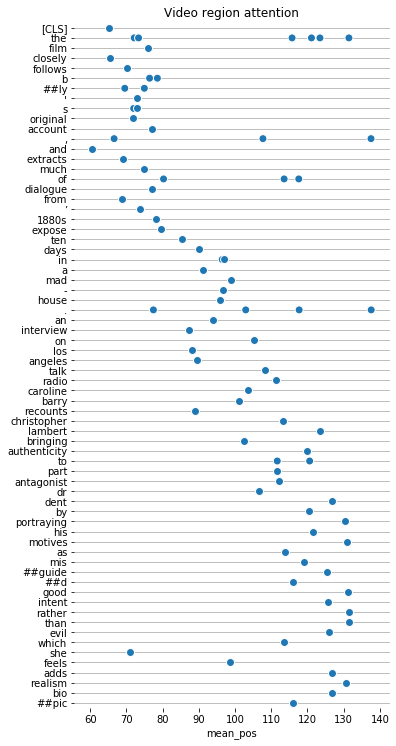

In [259]:
#sns.set_theme(style="whitegrid")

# Make the PairGrid
g = sns.PairGrid(mean_pos_by_token,
                 x_vars=["mean_pos"], y_vars=["token"],
                 height=10, aspect=.5)

# Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=8, orient="h", jitter=False,
      linewidth=1, edgecolor="w")

# Use the same x axis limits on all columns and add better labels
#g.set(xlim=(0, 200), xlabel="mean_pos", ylabel="")
g.set(xlabel="mean_pos", ylabel="")

ax = g.axes.flat[0]
# Set a different title for each axes
ax.set(title="Video region attention")

# Make the grid horizontal instead of vertical
ax.xaxis.grid(False)
ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)

In [260]:
positions_by_token = pd.DataFrame(columns=['pos','token'])

for i, row in enumerate(top_idxs_by_token):
    for col in row:
        positions_by_token = positions_by_token.append({'pos': col, 'token': text_tokens[i]}, ignore_index=True)

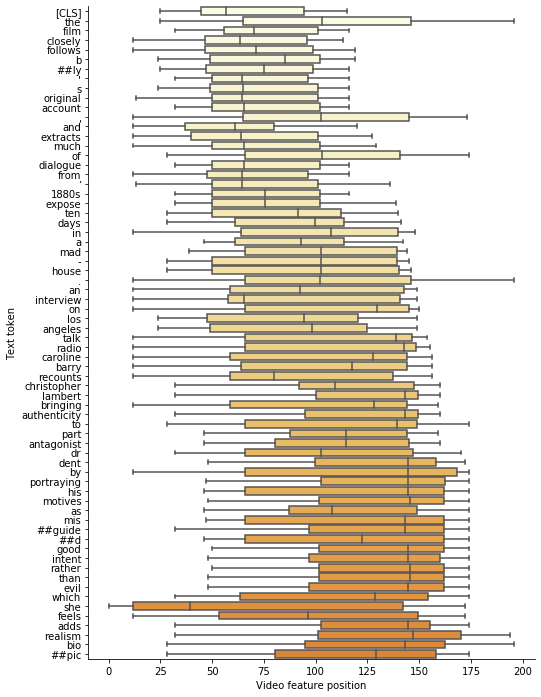

In [261]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 12)
sns.boxplot(x="pos", y="token", data=positions_by_token, ax=ax, palette=sns.color_palette("YlOrBr", 120)).set(
    xlabel='Video feature position', 
    ylabel='Text token'
)
sns.despine()

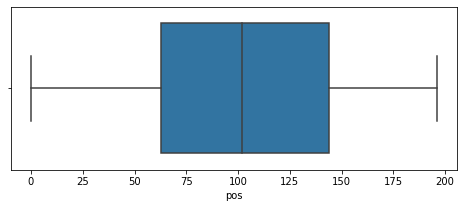

In [262]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 3)
sns.boxplot(x=positions_by_token.pos, ax=ax)

#### Audio

In [263]:
frames_attention_by_token = activations[f'trans_l_with_a.layers.0.self_attn'].squeeze(0).clone().numpy()
for i in range(1, 4):
    frames_attention_by_token += activations[f'trans_l_with_a.layers.{i}.self_attn'].squeeze(0).clone().numpy()

top_idxs_by_token = np.argsort(frames_attention_by_token, axis=1)[:,-20:]
mean_pos_by_token = pd.DataFrame({"token": text_tokens, "mean_pos": np.mean(top_idxs_by_token, axis=1).tolist()})

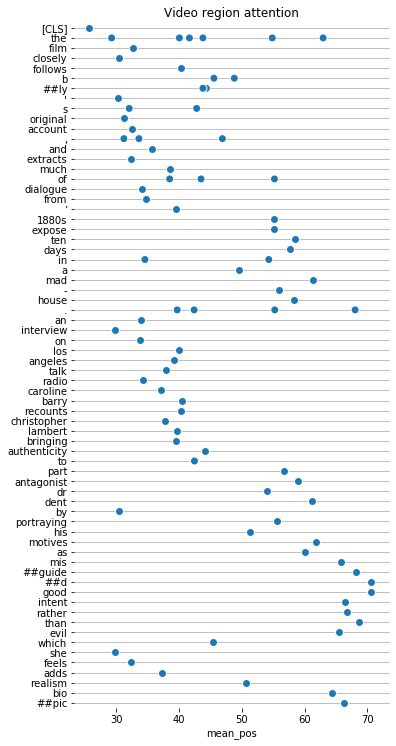

In [264]:
#sns.set_theme(style="whitegrid")

# Make the PairGrid
g = sns.PairGrid(mean_pos_by_token,
                 x_vars=["mean_pos"], y_vars=["token"],
                 height=10, aspect=.5)

# Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=8, orient="h", jitter=False,
      linewidth=1, edgecolor="w")

# Use the same x axis limits on all columns and add better labels
#g.set(xlim=(0, 200), xlabel="mean_pos", ylabel="")
g.set(xlabel="mean_pos", ylabel="")

ax = g.axes.flat[0]
# Set a different title for each axes
ax.set(title="Audio region attention")

# Make the grid horizontal instead of vertical
ax.xaxis.grid(False)
ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)

In [265]:
positions_by_token = pd.DataFrame(columns=['pos','token'])

for i, row in enumerate(top_idxs_by_token):
    for col in row:
        positions_by_token = positions_by_token.append({'pos': col, 'token': text_tokens[i]}, ignore_index=True)

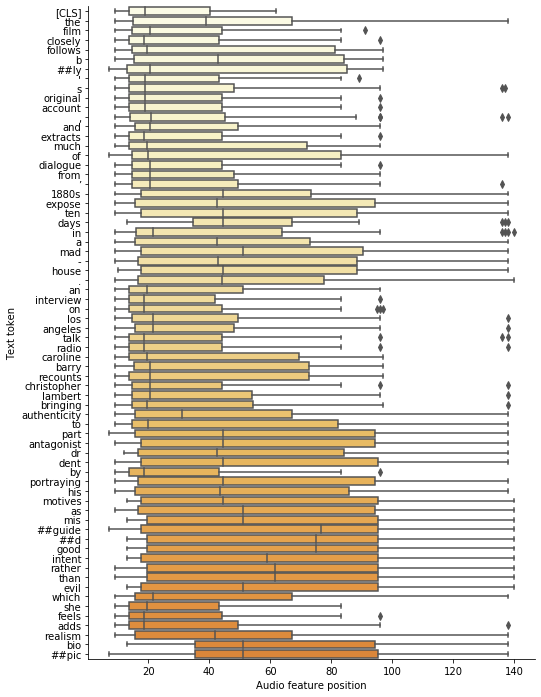

In [268]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 12)
sns.boxplot(x="pos", y="token", data=positions_by_token, ax=ax, palette=sns.color_palette("YlOrBr", 120)).set(
    xlabel='Audio feature position', 
    ylabel='Text token'
)
sns.despine()

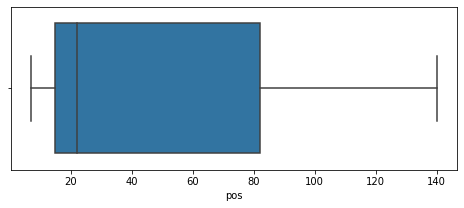

In [267]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 3)
sns.boxplot(x=positions_by_token.pos, ax=ax)

### Example with highest GMU activation for video modality

In [290]:
activations = {}

example_text = get_pred_hooks(model, test_set, id2setidx[4161], activations)

/001/usuarios/isaac.bribiesca/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/001/usuarios/isaac.bribiesca/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Get text tokens

In [291]:
text_tokens = id2token(example_text.detach().squeeze(0).numpy())
print(text_tokens)
print(len(text_tokens))

['[CLS]', 'fond', '##a', 'plays', 'ul', '##ee', 'jackson', ',', 'a', 'vietnam', 'vet', ',', 'widow', '##er', 'and', 'grandfather', '.', 'he', 'is', 'a', 'bee', '##keeper', 'by', 'profession', ',', 'who', 'raises', 'two', 'granddaughter', '##s', 'because', 'his', 'son', 'is', 'in', 'prison', 'and', 'his', 'daughter', '-', 'in', '-', 'law', 'helen', ',', 'a', 'drug', 'addict', ',', 'has', 'run', 'away', '.', 'the', 'son', 'imp', '##lore', '##s', 'him', 'to', 'look', 'for', 'his', 'wife', 'and', 'bring', 'her', 'home', '.', 'upon', 'returning', 'home', 'with', 'helen', ',', 'ul', '##ee', "'", 's', 'granddaughter', '##s', 'see', 'their', 'mother', 'going', 'through', 'withdrawal', ',', 'and', 'plead', 'with', 'their', 'neighbor', 'connie', 'to', 'help', 'her', '.', 'connie', 'is', 'a', 'twice', '-', 'divorced', 'nurse', 'who', 'assists', 'ul', '##ee', 'in', 'getting', 'his', 'daughter', '-', 'in', '-', 'law', 'through', 'det', '##ox', '.', 'the', 'film', 'shows', 'ul', '##ee', 'holding', '

Which modality (video or audio) has more relevance by text token

In [292]:
# sum of video attentions by text token for all layers
video_attention_by_token = get_max_activation_elements(activations, 'trans_v_with_l', 0)
# sum of audio attentions by text token for all layers
audio_attention_by_token = get_max_activation_elements(activations, 'trans_a_with_l', 0)
# concatenate both attention sums
vid_aud_attention_by_token = np.stack([video_attention_by_token, audio_attention_by_token], axis=1)
# take modality with highest attention for each token
max_modality_by_token = np.argmax(vid_aud_attention_by_token, axis=1)

In [293]:
max_modality_by_token

array([0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0])

In [294]:
s = colorize(text_tokens, max_modality_by_token/2)

# to display in ipython notebook
from IPython.display import display, HTML
display(HTML(s))

Frames attention by text token (take top frames attention by token)

In [295]:
frames_attention_by_token = activations['trans_l_with_v.layers.0.self_attn'].squeeze(0).clone().detach().numpy()
top_idxs_by_token = np.argsort(frames_attention_by_token, axis=1)[:,-20:]

In [296]:
top_idxs_by_token

array([[ 34,  38,   5, ...,  13,  10,  43],
       [  1,  34,   0, ...,  13,  11,  43],
       [ 25,  34,   5, ...,  10,  43,  45],
       ...,
       [109,   0,   1, ...,  51,  54,  53],
       [127,   0, 189, ...,  54,  51,  53],
       [ 54,  52,  55, ...,  34,   1,   0]])

Text with visual attention (v_with_l)

In [297]:
attention_values = get_max_activation_elements(activations, 'trans_v_with_l', 0)
max_idxs = attention_values.argsort()[-10:][::-1]

for i in range(attention_values.shape[0]):
    if i not in max_idxs:
        attention_values[i] = 0

In [298]:
s = colorize(text_tokens, attention_values)

# to display in ipython notebook
from IPython.display import display, HTML
display(HTML(s))

Text with audio attention (a_with_l)

In [299]:
attention_values = get_max_activation_elements(activations, 'trans_a_with_l', 0)
max_idxs = attention_values.argsort()[-10:][::-1]

for i in range(attention_values.shape[0]):
    if i not in max_idxs:
        attention_values[i] = 0

In [300]:
s = colorize(text_tokens, attention_values)

# to display in ipython notebook
from IPython.display import display, HTML
display(HTML(s))

Visualize major regions of attention by video or audio per token

#### Video

In [311]:
frames_attention_by_token = activations[f'trans_l_with_v.layers.0.self_attn'].squeeze(0).clone().numpy()
for i in range(1, 4):
    frames_attention_by_token += activations[f'trans_l_with_v.layers.{i}.self_attn'].squeeze(0).clone().numpy()

top_idxs_by_token = np.argsort(frames_attention_by_token, axis=1)[:,-20:]
mean_pos_by_token = pd.DataFrame({"token": text_tokens, "mean_pos": np.mean(top_idxs_by_token, axis=1).tolist()})

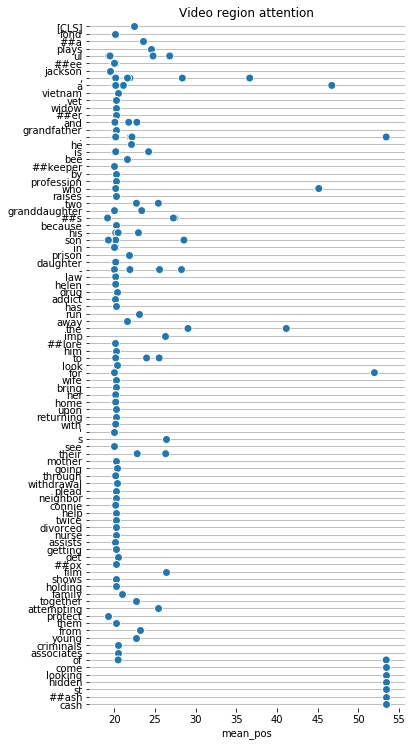

In [302]:
#sns.set_theme(style="whitegrid")

# Make the PairGrid
g = sns.PairGrid(mean_pos_by_token,
                 x_vars=["mean_pos"], y_vars=["token"],
                 height=10, aspect=.5)

# Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=8, orient="h", jitter=False,
      linewidth=1, edgecolor="w")

# Use the same x axis limits on all columns and add better labels
#g.set(xlim=(0, 200), xlabel="mean_pos", ylabel="")
g.set(xlabel="mean_pos", ylabel="")

ax = g.axes.flat[0]
# Set a different title for each axes
ax.set(title="Video region attention")

# Make the grid horizontal instead of vertical
ax.xaxis.grid(False)
ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)

In [312]:
positions_by_token = pd.DataFrame(columns=['pos','token'])

for i, row in enumerate(top_idxs_by_token):
    for col in row:
        positions_by_token = positions_by_token.append({'pos': col, 'token': text_tokens[i]}, ignore_index=True)

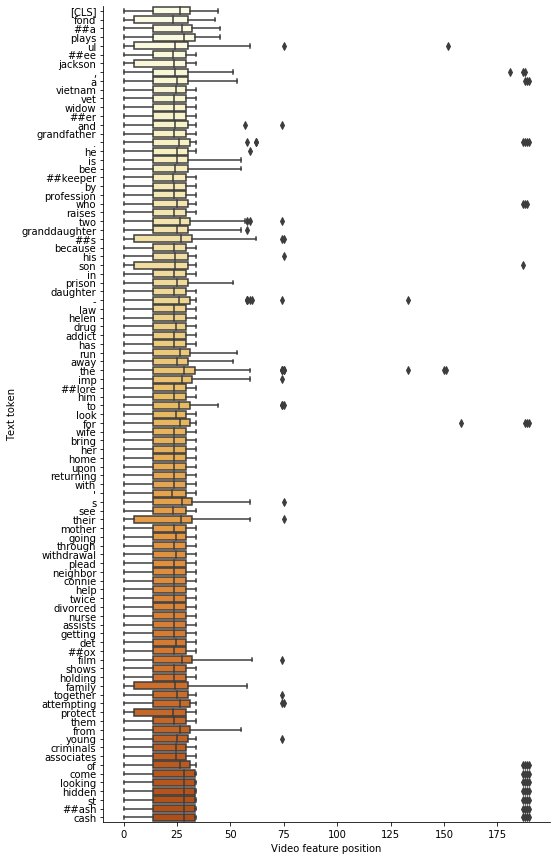

In [314]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 15)
sns.boxplot(x="pos", y="token", data=positions_by_token, ax=ax, palette=sns.color_palette("YlOrBr", 120)).set(
    xlabel='Video feature position', 
    ylabel='Text token'
)
sns.despine()

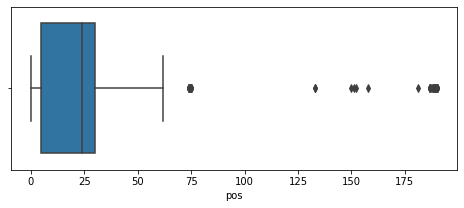

In [305]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 3)
sns.boxplot(x=positions_by_token.pos, ax=ax)

#### Audio

In [315]:
frames_attention_by_token = activations[f'trans_l_with_a.layers.0.self_attn'].squeeze(0).clone().numpy()
for i in range(1, 4):
    frames_attention_by_token += activations[f'trans_l_with_a.layers.{i}.self_attn'].squeeze(0).clone().numpy()

top_idxs_by_token = np.argsort(frames_attention_by_token, axis=1)[:,-20:]
mean_pos_by_token = pd.DataFrame({"token": text_tokens, "mean_pos": np.mean(top_idxs_by_token, axis=1).tolist()})

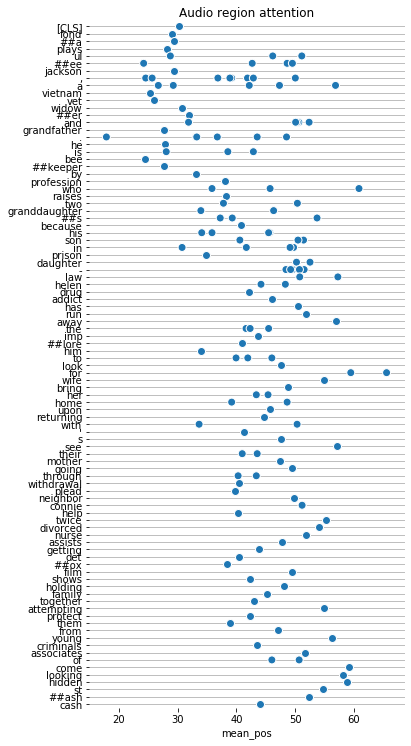

In [307]:
#sns.set_theme(style="whitegrid")

# Make the PairGrid
g = sns.PairGrid(mean_pos_by_token,
                 x_vars=["mean_pos"], y_vars=["token"],
                 height=10, aspect=.5)

# Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=8, orient="h", jitter=False,
      linewidth=1, edgecolor="w")

# Use the same x axis limits on all columns and add better labels
#g.set(xlim=(0, 200), xlabel="mean_pos", ylabel="")
g.set(xlabel="mean_pos", ylabel="")

ax = g.axes.flat[0]
# Set a different title for each axes
ax.set(title="Audio region attention")

# Make the grid horizontal instead of vertical
ax.xaxis.grid(False)
ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)

In [316]:
positions_by_token = pd.DataFrame(columns=['pos','token'])

for i, row in enumerate(top_idxs_by_token):
    for col in row:
        positions_by_token = positions_by_token.append({'pos': col, 'token': text_tokens[i]}, ignore_index=True)

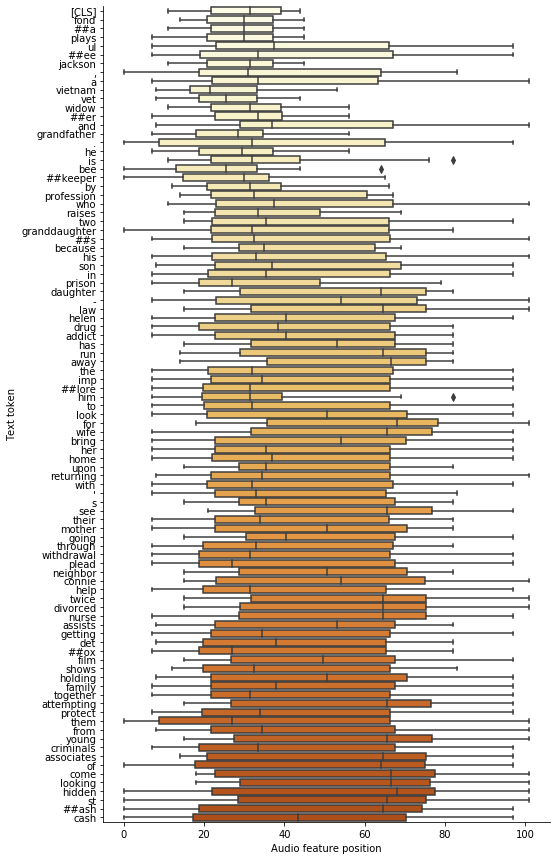

In [317]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 15)
sns.boxplot(x="pos", y="token", data=positions_by_token, ax=ax, palette=sns.color_palette("YlOrBr", 120)).set(
    xlabel='Audio feature position', 
    ylabel='Text token'
)
sns.despine()

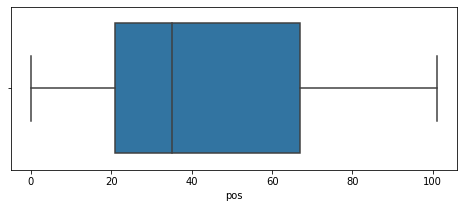

In [310]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 3)
sns.boxplot(x=positions_by_token.pos, ax=ax)

### Word clouds by genre

Funciton to get the 'k' tokens with most activation in cross-modal attention with video/audio

In [138]:
def get_k_max_words(example_id, k, model, test_set, id2token, id2setidx, layer_type):
    activations = {}
    example_text = get_pred_hooks(model, test_set, id2setidx[example_id], activations)
    
    attention_values = get_max_activation_elements(activations, layer_type, 0)
    max_idxs = attention_values.argsort()[-k:][::-1]
    
    example_tokens = id2token(example_text.detach().squeeze(0).numpy())
    
    return [example_tokens[i] for i in max_idxs if example_tokens[i]]

Load test genres and observation ids

In [153]:
test_data = []

with open("/001/usuarios/isaac.bribiesca/moviescope/test.jsonl", "r") as f:
    for line in f:
        movie = json.loads(line)
        test_data.append({'genres': movie['label'],
                         'id': movie['id']})

Filter test observations by genre and get k most activated words by video/audio

In [157]:
def words_by_genre_modality(k, model, test_set, id2token, id2setidx, layer_type, genre, test_data):
    genre_observations = [example for example in test_data if genre in example['genres']]
    
    all_max_tokens = []
    for movie in genre_observations:
        max_tokens = get_k_max_words(movie['id'], k, model, test_set, id2token, id2setidx, layer_type)
        all_max_tokens.append(max_tokens)
    
    return all_max_tokens

In [158]:
all_words_by_genre = words_by_genre_modality(10, model, test_set, id2token, id2setidx, 'trans_v_with_l', 'Horror', test_data)

/opt/conda/conda-bld/pytorch_1591914855613/work/aten/src/ATen/native/RangeFactories.cpp:195: UserWarning: The number of elements in the out tensor of shape [200] is 200 which does not match the computed number of elements 512. Note that this may occur as a result of rounding error. The out tensor will be resized to a tensor of shape (512,).


In [171]:
genre_words_concat = [" ".join(t) for t in all_words_by_genre]
genre_words_doc = ""

for s in genre_words_concat:
    genre_words_doc += " " + s

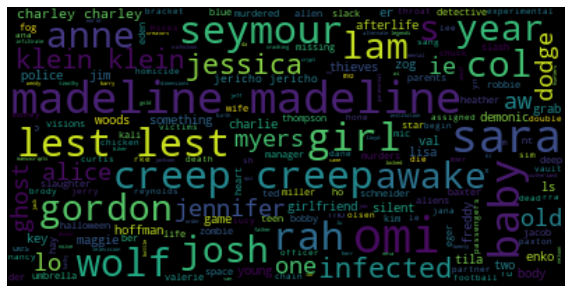

In [184]:
wordcloud = WordCloud(max_font_size=35).generate(genre_words_doc)
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
from collections import Counter

Counter([w for l in all_words_by_genre for w in l]).most_common()

In [143]:
max_tokens = get_k_max_words(3899, 10, model, test_set, id2token, id2setidx, 'trans_v_with_l')

#### Iterate through all genres for Video modality

In [192]:
all_genres = list(set([g for obs in test_data for g in obs['genres']]))

Horror


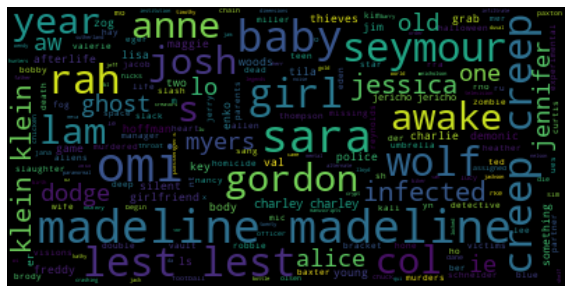

Mystery


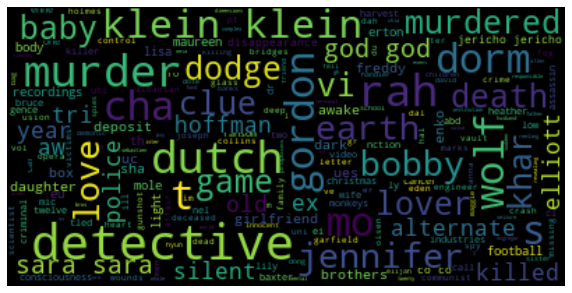

Romance


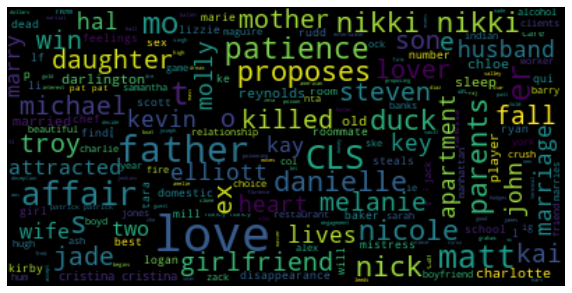

Sci-Fi


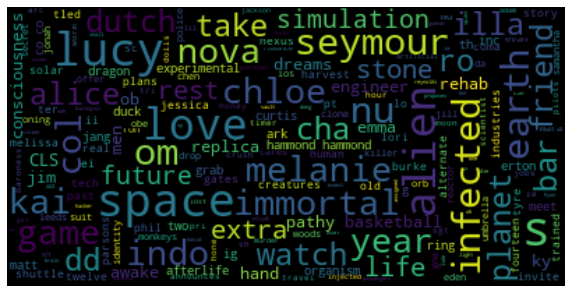

Family


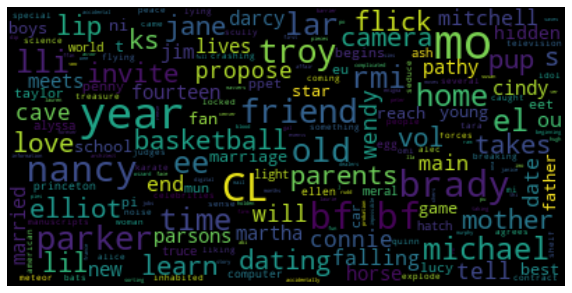

Drama


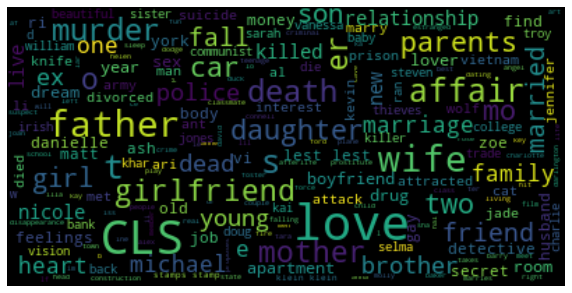

Action


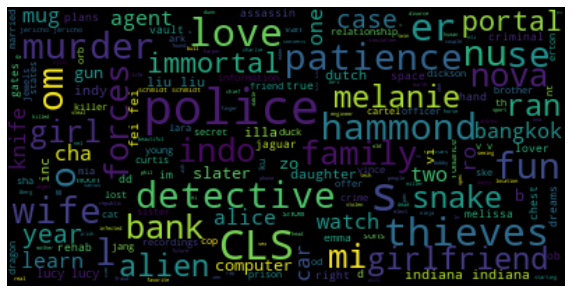

Animation


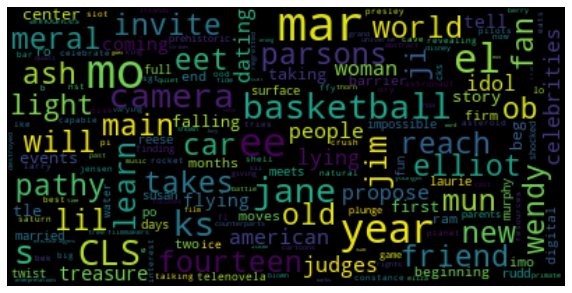

Thriller


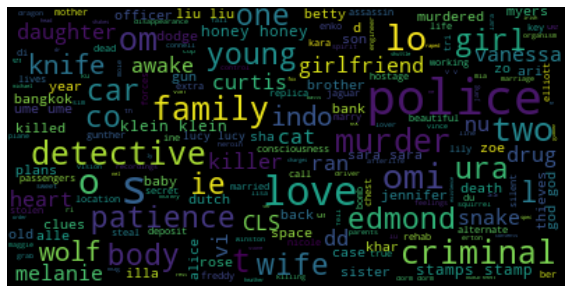

Fantasy


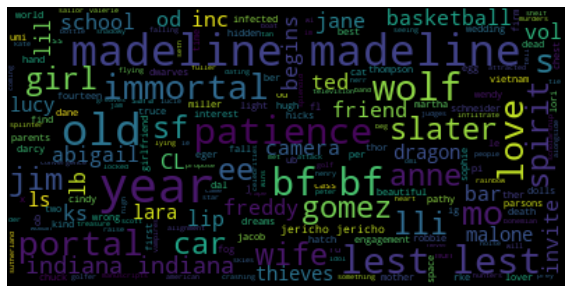

Biography


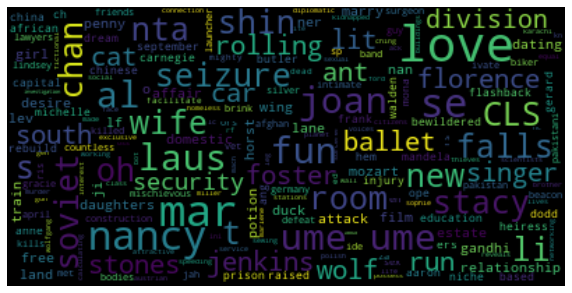

Crime


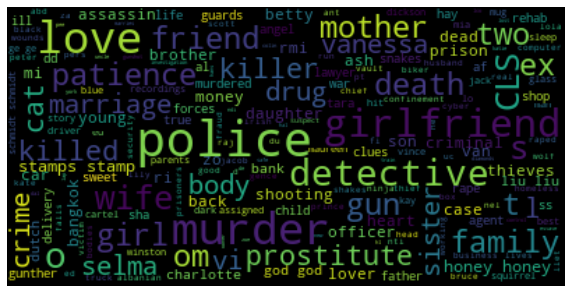

Comedy


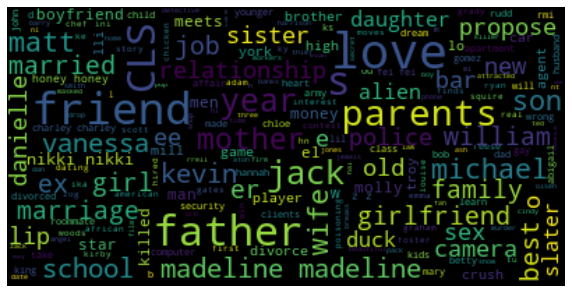

In [194]:
for genre in all_genres:
    # get words
    all_words_by_genre = words_by_genre_modality(10, model, test_set, id2token, id2setidx, 'trans_v_with_l', genre, test_data)
    
    # concatenate words in one string
    genre_words_concat = [" ".join(t) for t in all_words_by_genre]
    genre_words_doc = ""

    for s in genre_words_concat:
        genre_words_doc += " " + s
        
    # plot wordcloud
    print(genre)
    wordcloud = WordCloud(max_font_size=35).generate(genre_words_doc)
    plt.figure(figsize=(10, 10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

#### Iterate through all genres for Audio modality

Horror


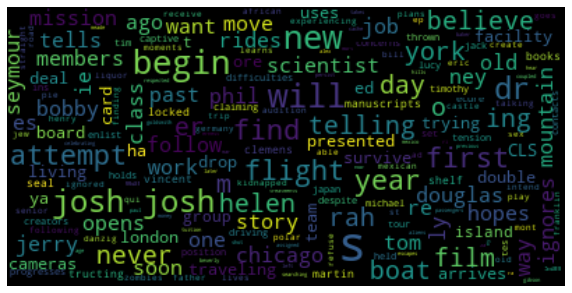

Mystery


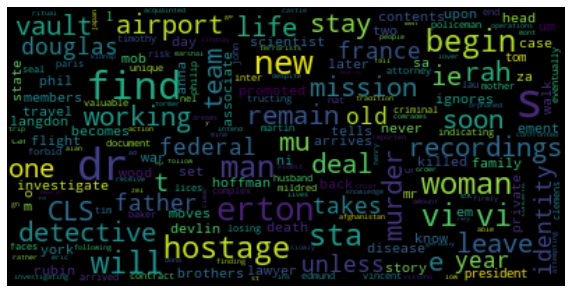

Romance


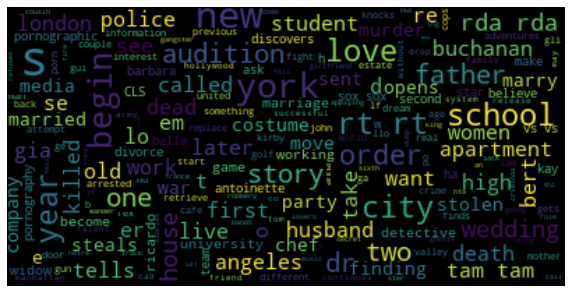

Sci-Fi


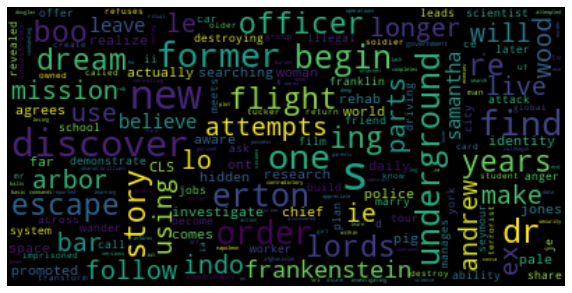

Family


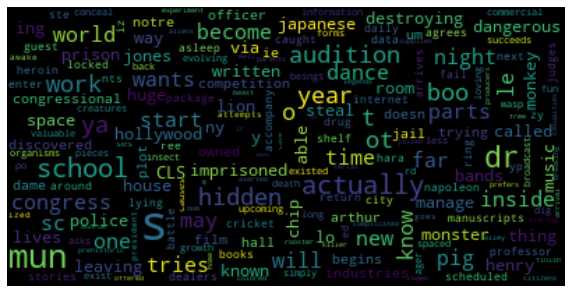

Drama


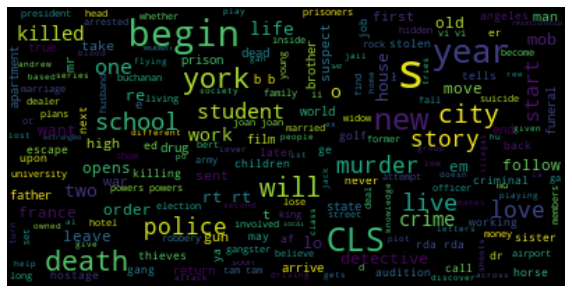

Action


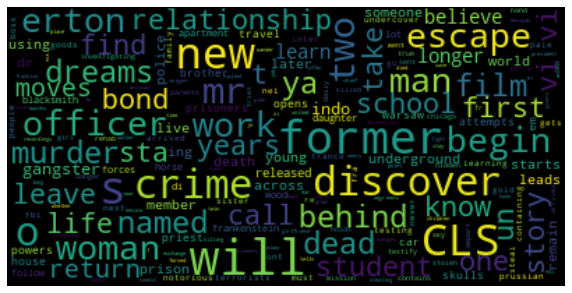

Animation


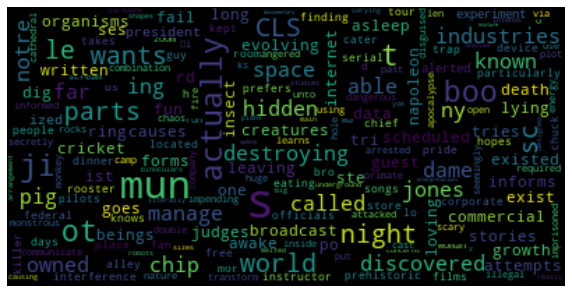

Thriller


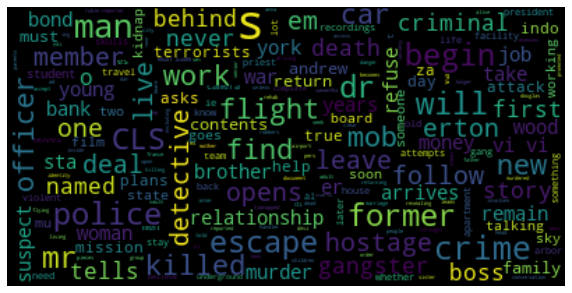

Fantasy


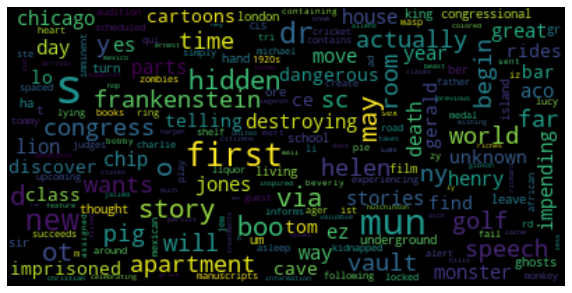

Biography


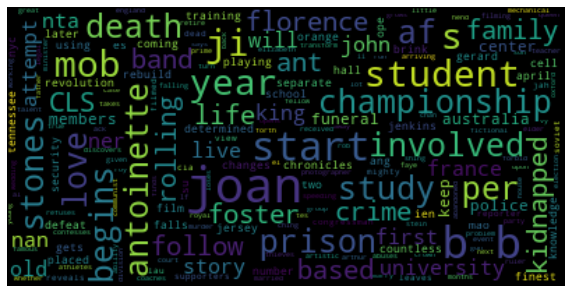

Crime


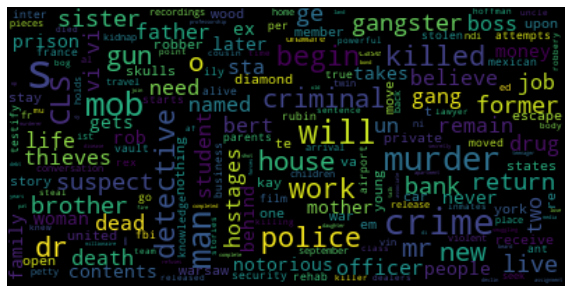

Comedy


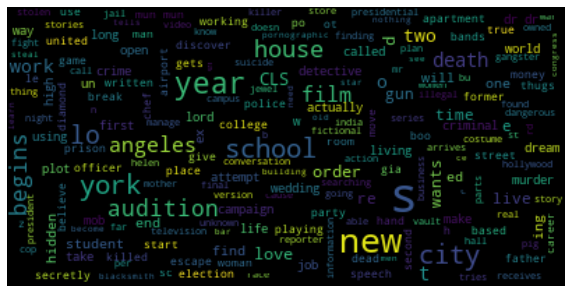

In [195]:
for genre in all_genres:
    # get words
    all_words_by_genre = words_by_genre_modality(10, model, test_set, id2token, id2setidx, 'trans_a_with_l', genre, test_data)
    
    # concatenate words in one string
    genre_words_concat = [" ".join(t) for t in all_words_by_genre]
    genre_words_doc = ""

    for s in genre_words_concat:
        genre_words_doc += " " + s
        
    # plot wordcloud
    print(genre)
    wordcloud = WordCloud(max_font_size=35).generate(genre_words_doc)
    plt.figure(figsize=(10, 10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

### Get gradients between two layers (test)

In [236]:
activations = {}

example_text = get_pred_gradient_hooks(model, test_set, id2setidx[3899], activations)

In [214]:
att = activations['trans_l_with_v.emb.1']
att = att.squeeze(1)[0]
emb = activations['embeddings']
grad_outputs = torch.ones_like(att)

#att_ = att.reshape(-1)
#grad_outputs = torch.zeros_like(att_)
#grad_outputs[0] = 1

gradients = torch.autograd.grad(outputs=att,
                                inputs=emb,
                                grad_outputs=grad_outputs,
                                create_graph=False, retain_graph=True, only_inputs=True)[0].squeeze(0)

In [215]:
att.shape

torch.Size([768])

In [216]:
emb.shape

torch.Size([1, 90, 768])

In [217]:
gradients.shape

torch.Size([90, 768])

In [218]:
gradients

tensor([[ 0.6975, -0.6015,  0.2793,  ...,  0.2281, -0.4250,  0.4595],
        [ 0.0112, -0.4238,  0.2672,  ...,  0.4062, -0.0665, -0.3486],
        [ 0.2734,  0.4687,  0.3028,  ...,  0.1208, -0.2031, -0.6101],
        ...,
        [-0.1101, -0.0355,  0.2059,  ...,  0.6109,  0.1181, -0.1234],
        [ 0.1302, -0.1070,  0.1389,  ...,  0.1116,  0.1415, -0.2617],
        [-0.4466,  0.0606,  0.1634,  ...,  0.2345, -0.0830, -0.2073]])

In [223]:
torch.norm(gradients, 2, dim=1).shape

torch.Size([90])

In [126]:
def jacobian(y, x, create_graph=False):                                                               
    jac = []                                                                                          
    flat_y = y.reshape(-1)                                                                            
    grad_y = torch.zeros_like(flat_y)                                                                 
    for i in range(len(flat_y)):                                                                      
        grad_y[i] = 1.                                                                                
        grad_x, = torch.autograd.grad(flat_y, x, grad_y, retain_graph=True, create_graph=create_graph)
        jac.append(grad_x.reshape(x.shape))                                                           
        grad_y[i] = 0.                                                                                
    return torch.stack(jac).reshape(y.shape + x.shape)    

### Gradients

In [258]:
def get_gradients(inputs, outputs):
    grads = []
    outputs_matrix = outputs.squeeze(1)
    seq_len = outputs.shape[0]
    
    for i in range(seq_len):
        if i%10==0:
            print(i)
        outputs_matrix_elem = outputs_matrix[i]
        grad_outputs = torch.ones_like(outputs_matrix_elem)
        gradients = torch.autograd.grad(outputs=outputs_matrix_elem,
                                        inputs=inputs,
                                        grad_outputs=grad_outputs,
                                        create_graph=False,
                                        retain_graph=True,
                                        only_inputs=True)[0].squeeze(0)
        
        grads.append(torch.norm(gradients, 2, dim=1).numpy())
        
    return np.array(grads)

In [383]:
activations = {}
example_text = get_pred_gradient_hooks(model, test_set, id2setidx[3899], activations)

jacobian_matrix = get_gradients(activations['embeddings'], activations['trans_l_with_v.emb.3'], )

0
10
20
30
40
50
60
70
80


In [384]:
text_tokens = id2token(example_text.detach().squeeze(0).numpy())

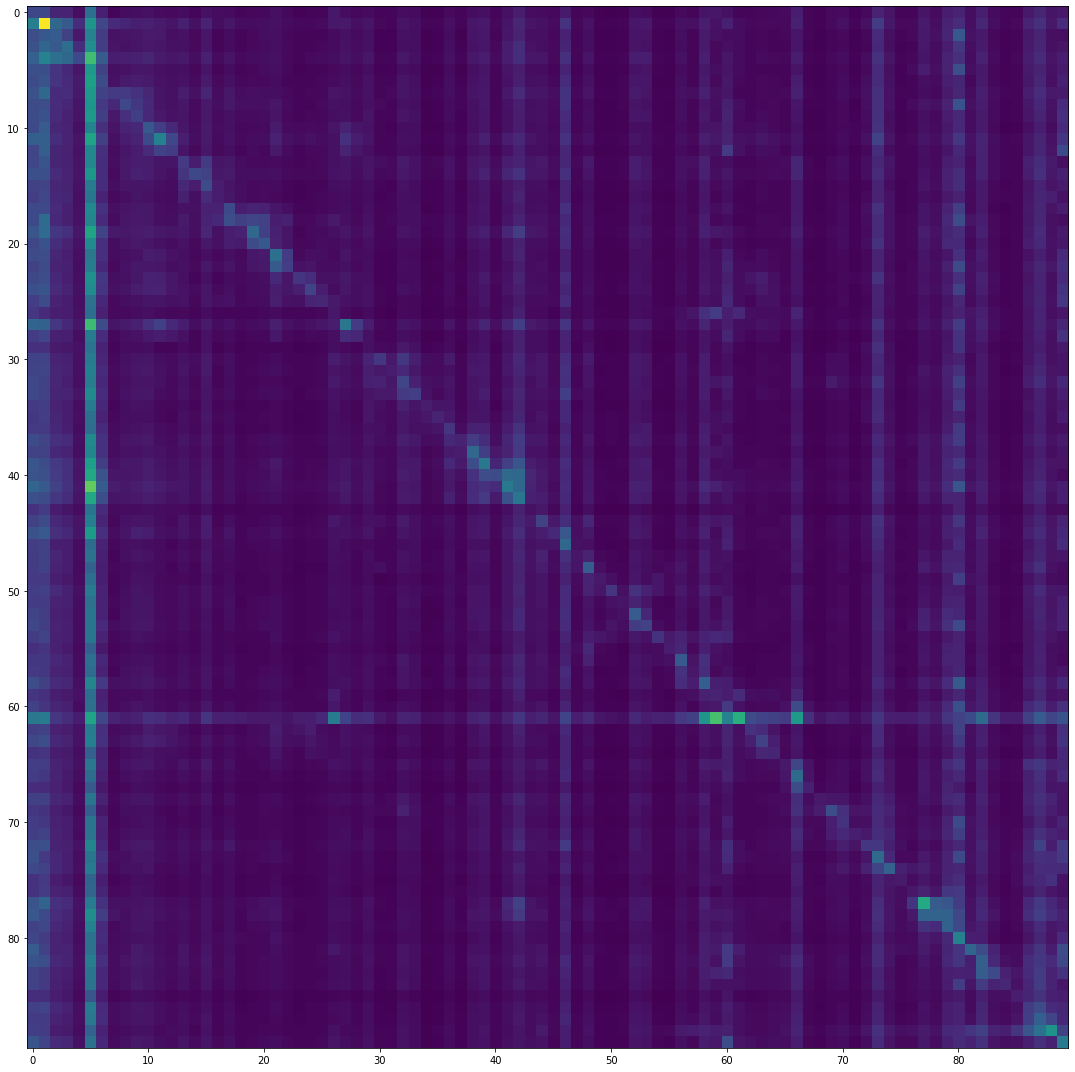

In [386]:
show(torch.from_numpy(jacobian_matrix), text_tokens)